# SISO system simulation and identification

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import os
os.chdir('/content/drive/MyDrive/Proyecto_Splra')

In [21]:
cd SIPPY-master/

/content/drive/MyDrive/Proyecto_Splra/SIPPY-master


In [ ]:
!pip install scikit-build
!pip install setuptools_scm
!pip install control -U
!pip install scienceplots
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended texlive-latex-recommended cm-super

In [ ]:
!python setup.py install

In [22]:
from __future__ import division
from past.utils import old_div
from sippy import *
from sippy import functionset as fset
import numpy as np
import pandas as pd
import control as cnt
import matplotlib.pyplot as plt
np.random.seed(3021984)

import warnings
warnings.filterwarnings('ignore')

import os
import sys
sys.path.append('/content/drive/MyDrive/Proyecto_Splra/Python')

import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 500
mpl.rcParams['savefig.format'] = 'svg'
mpl.rcParams['font.family'] = 'serif'

In [25]:
from Lra_Modeling import *
from Sparse_Lra import *

## System definition and simulation

In [26]:
# Define sampling time and Time vector
sampling_time = 1.                                  # [s]
end_time = 500                                     # [s]
npts = int(old_div(end_time, sampling_time)) + 1
Time = np.linspace(0, end_time, npts)

In [27]:
# Define Generalize Binary Sequence as input signal
switch_probability = 0.08  # [0..1]
[Usim,_,_] = fset.GBN_seq(npts, switch_probability, Range = [-1, 1])

In [28]:
# ### Numerator of noise transfer function has two roots: nc = 2
NUM_H = [1., 0.3, 0.2, 0., 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]

# ### Common denominator between input and noise transfer functions has 4 roots: na = 4
DEN = [1., -2.21, 1.7494, -0.584256, 0.0684029, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
# ### Numerator of input transfer function has 3 roots: nb = 3
NUM = [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,1.5, -2.07, 1.3146]

# ### Define transfer functions
G = cnt.tf(NUM, DEN, sampling_time)

In [29]:
G

TransferFunction(array([ 1.5   , -2.07  ,  1.3146]), array([ 1.       , -2.21     ,  1.7494   , -0.584256 ,  0.0684029,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ]), 1.0)

In [31]:
Y1, Time, Xsim = cnt.matlab.lsim(G, Usim, Time)

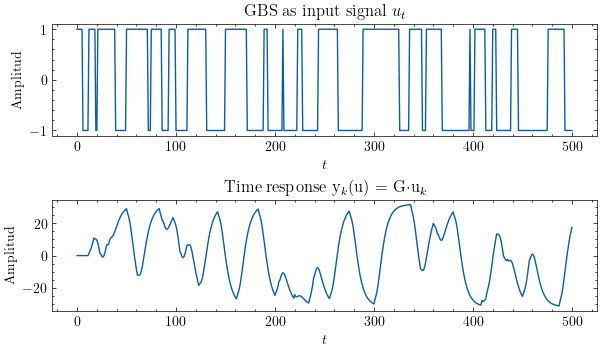

In [32]:
with plt.style.context(['science']):
    fig, axs = plt.subplots(2,1,layout='constrained',figsize=(6, 3.5))
    axs[0].plot(Time, Usim,label='$u_t$')
    axs[0].set_xlabel('$t$')
    axs[0].set_ylabel('Amplitud')
    axs[0].set_title('GBS as input signal $u_t$')

    axs[1].plot(Time, Y1,label='$y_t$')
    axs[1].set_xlabel('$t$')
    axs[1].set_ylabel('Amplitud')
    axs[1].set_title('Time response y$_k$(u) = G$\cdot$u$_k$')

    #plt.savefig('siso_01.svg')
    plt.show()


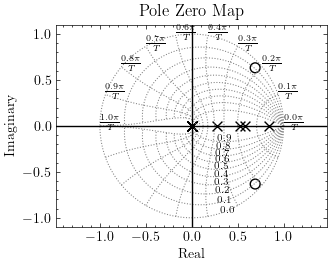

In [ ]:
with plt.style.context(['science']):
    cnt.pzmap(G,grid=True)
    #plt.savefig('siso_02.jpg')
    plt.show()

In [ ]:
cnt.zeros(G),cnt.poles(G)

(array([0.69+0.63269266j, 0.69-0.63269266j]),
 array([0.83999958+0.j, 0.58000414+0.j, 0.51999583+0.j, 0.27000045+0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j]))

## Validation sample

In [33]:
np.random.seed(3022023)
[Uval,_,_] = fset.GBN_seq(npts, switch_probability, Range = [-1.5, 1.5])
Yval, Time, Xsim_val = cnt.matlab.lsim(G, Uval, Time)

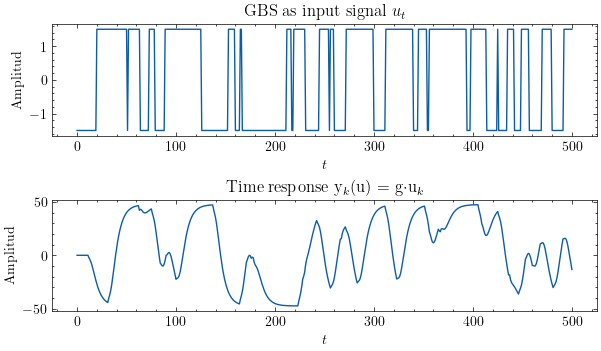

In [34]:
with plt.style.context(['science']):
    fig, axs = plt.subplots(2,1,layout='constrained',figsize=(6, 3.5))
    axs[0].plot(Time, Uval,label='$u_t$')
    axs[0].set_xlabel('$t$')
    axs[0].set_ylabel('Amplitud')
    axs[0].set_title('GBS as input signal $u_t$')

    axs[1].plot(Time, Yval,label='$y_t$')
    axs[1].set_xlabel('$t$')
    axs[1].set_ylabel('Amplitud')
    axs[1].set_title('Time response y$_k$(u) = g$\cdot$u$_k$')

    #plt.savefig('siso_val.jpg')
    plt.show()

## Exact system identification

### $\sigma^2=0.00$

### Sippy

In [35]:
sys_sippy_arx = system_identification(Y1, Usim, 'ARX',IC='AIC')

suggested orders are: Na= 5 ; Nb= 5 Delay:  5


In [36]:
sys_sippy_arx.G

TransferFunction(array([ 0.00868905,  0.07471354, -0.16321831,  0.0460905 ,  0.49642357]), array([ 1.        , -1.65075565,  0.42247818,  0.12685221,  0.32163217,
       -0.20187222,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ]), 1.0)

In [37]:
Yid_sippy_arx, Time, Xid_sippy_arx = cnt.matlab.lsim(sys_sippy_arx.G, Usim, Time)

In [38]:
1-(la.norm(Y1-Yid_sippy_arx)/la.norm(Y1-np.mean(Y1)))

0.8196573059466183

In [39]:
Yval_sippy_arx, Time, Xval_sippy_arx = cnt.matlab.lsim(sys_sippy_arx.G, Uval, Time)

In [40]:
1-(la.norm(Yval-Yval_sippy_arx)/la.norm(Yval-np.mean(Yval)))

0.8067597541323169

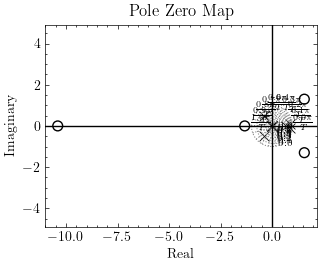

In [ ]:
cnt.pzmap(sys_sippy_arx.G,grid=True)
plt.show()

In [ ]:
sys_sippy_armax = system_identification(Y1, Usim, 'ARMAX',IC='AIC')

Armax model:
- Params:
  na: 4 (0, 5)
  nb: 5 (1, 5)
  nc: 5 (0, 5)
  delay: 5 (0, 5)
  dt: 1.0 
  method: AIC 
  max iterations: 200 
- Output:
  G: 
0.0009625 z^4 + 0.03033 z^3 - 0.0265 z^2 - 0.3135 z + 0.7013
------------------------------------------------------------
   z^10 - 0.3608 z^9 - 4.475 z^8 + 6.252 z^7 - 2.411 z^6

dt = 1.0
 
  H: 
z^10 + 0.9309 z^9 - 3.011 z^8 + 0.912 z^7 + 0.0372 z^6 + 0.2759 z^5
-------------------------------------------------------------------
       z^10 - 0.3608 z^9 - 4.475 z^8 + 6.252 z^7 - 2.411 z^6

dt = 1.0
 
  Vn: 0.00026276803785681385 
  Model Output: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  3.92595798e-01  2.71295083e-02
   1.62361264e+00  4.51204611e-01  7.66686518e+00  5.68104541e+00
   7.28295957e+00  1.03673960e+01  1.27017399e+01  1.38813686e+01
   2.36326131e+00  8.89083575e+00  6.72643685e+00  1.81486726e+00
 

In [ ]:
Yid_sippy_armax, Time, Xid_sippy_armax = cnt.matlab.lsim(sys_sippy_armax.G, Usim, Time)
1-(la.norm(Y1-Yid_sippy_arx)/la.norm(Y1-np.mean(Y1)))

0.8196573059466183

In [ ]:
Yval_sippy_armax, Time, Xval_sippy_armax = cnt.matlab.lsim(sys_sippy_armax.G, Uval, Time)
1-(la.norm(Yval-Yval_sippy_arx)/la.norm(Yval-np.mean(Yval)))

0.8067597541323169

### SpLra

In [ ]:
w=np.block([[Usim],[Y1]])

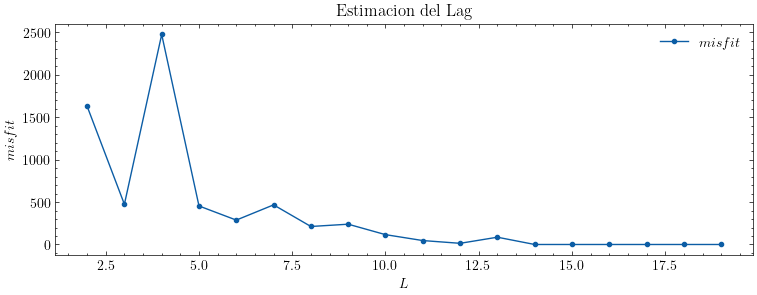

In [ ]:
lag_est(w,20,1,1e-3,1e-3)

In [ ]:
M0,fit0,wh0,R_sp0,sys_tf0,sys_ss0,x0= Sparse_lra_sysid(w,14,1)

In [ ]:
M0,fit0

(2.951388318762404e-11, 99.99999999999295)

In [ ]:
sys_tf0

TransferFunction(array([ 1.5   , -2.07  ,  1.3146]), array([ 1.       , -2.21     ,  1.7494   , -0.584256 ,  0.0684029,
       -0.       , -0.       , -0.       , -0.       , -0.       ,
       -0.       , -0.       , -0.       , -0.       , -0.       ]), 1)

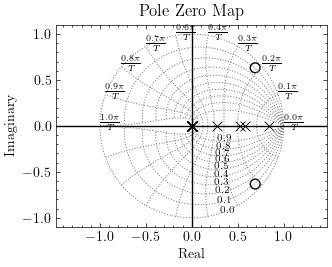

In [ ]:
cnt.pzmap(sys_tf0,grid=True)
plt.show()

In [ ]:
Yval_lra, Time, Xval_lra = cnt.matlab.lsim(sys_tf0, Uval, Time)
1-(la.norm(Yval-Yval_lra)/la.norm(Yval-np.mean(Yval)))

0.9999999999999308

## Adding noise (Armax structure)

In [ ]:
H_sample = cnt.tf(NUM_H, DEN, sampling_time)

In [ ]:
H_sample

TransferFunction(array([1. , 0.3, 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. ]), array([ 1.       , -2.21     ,  1.7494   , -0.584256 ,  0.0684029,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ]), 1.0)

In [ ]:
# Define white noise as noise signal
white_noise_variance = [0.01]
e_t = fset.white_noise_var(Usim.size, white_noise_variance)[0]

In [ ]:
Y2, Time, X2 = cnt.matlab.lsim(H_sample, e_t, Time)

In [ ]:
ytot = Y1 + Y2
utot = Usim + e_t

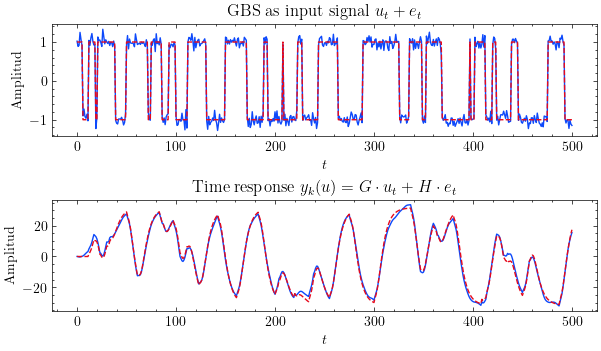

In [ ]:
with plt.style.context(['science', 'high-vis']):
    fig, axs = plt.subplots(2,1,layout='constrained',figsize=(6, 3.5))
    axs[0].plot(Time, utot,label='$u_{tot}$')
    axs[0].plot(Time, Usim,label='$u_{y}$')
    axs[0].set_xlabel('$t$')
    axs[0].set_ylabel('Amplitud')
    axs[0].set_title('GBS as input signal $u_t+e_t$ ')

    axs[1].plot(Time, ytot,label='$y_{tot}$')
    axs[1].plot(Time, Y1,label='$y_{t}$')
    axs[1].set_xlabel('$t$')
    axs[1].set_ylabel('Amplitud')
    axs[1].set_title('Time response $y_k(u) = G \cdot u_{t} + H \cdot e_{t}$')
    #plt.savefig('siso_armax.jpg')
    plt.show()

In [ ]:
wr = np.block([[Usim],[ytot]])

## LRA modeling

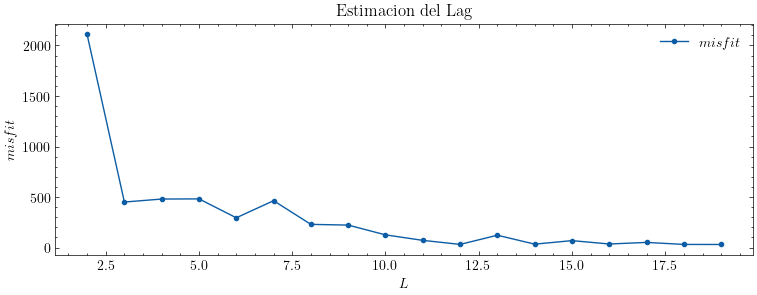

In [ ]:
lag_est(wr,20,1,1e-1,1e-1)

In [ ]:
M,fit,wh,R_sp,sys_tf,sys_ss,x0= Sparse_lra_sysid(wr,14,1,tol=1e-1,delta=1e-1)

In [ ]:
M,fit

(37.413196464182946, 90.91944494139608)

In [ ]:
Yidr, Time, Xsim_idr = cnt.matlab.lsim(sys_tf, Usim, Time)
Yvalr, Time, Xsim_valr = cnt.matlab.lsim(sys_tf, Uval, Time)

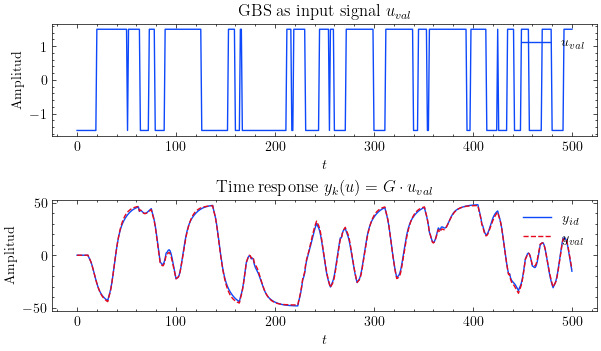

In [ ]:
with plt.style.context(['science', 'high-vis']):
    fig, axs = plt.subplots(2,1,layout='constrained',figsize=(6, 3.5))
    axs[0].plot(Time, Uval,label='$u_{val}$')
    axs[0].legend()
    axs[0].set_xlabel('$t$')
    axs[0].set_ylabel('Amplitud')
    axs[0].set_title('GBS as input signal $u_{val}$ ')

    axs[1].plot(Time, Yvalr ,label='$y_{id}$')
    axs[1].plot(Time, Yval,label='$y_{val}$')
    axs[1].legend()
    axs[1].set_xlabel('$t$')
    axs[1].set_ylabel('Amplitud')
    axs[1].set_title('Time response $y_k(u) = G \cdot u_{val}$')
    plt.savefig('siso_val_final.jpg')
    plt.show()

In [ ]:
1-(la.norm(Y1-Yidr)/la.norm(Y1-np.mean(Y1))),1-(la.norm(Yval-Yvalr)/la.norm(Yval-np.mean(Yval)))

(0.9549437946653015, 0.9576810642899953)

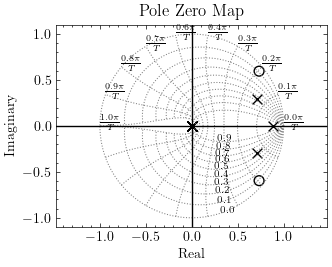

In [ ]:
with plt.style.context(['science', 'high-vis']):
    cnt.pzmap(sys_tf,grid=True)
    plt.savefig('siso_val_pzmap.jpg')
    plt.show()

## Sippy Armax modeling

In [ ]:
sys_armax = system_identification(ytot, Usim, 'ARMAX',IC='AIC')

Armax model:
- Params:
  na: 3 (0, 5)
  nb: 5 (1, 5)
  nc: 5 (0, 5)
  delay: 5 (0, 5)
  dt: 1.0 
  method: AIC 
  max iterations: 200 
- Output:
  G: 
-0.05931 z^4 + 0.1624 z^3 - 0.1924 z^2 + 0.3545 z - 0.4384
----------------------------------------------------------
         z^10 - 3.799 z^9 + 4.57 z^8 - 1.787 z^7

dt = 1.0
 
  H: 
z^10 - 2.397 z^9 + 0.9087 z^8 + 0.5417 z^7 - 0.4898 z^6 - 0.1584 z^5
--------------------------------------------------------------------
              z^10 - 3.799 z^9 + 4.57 z^8 - 1.787 z^7

dt = 1.0
 
  Vn: 0.000336602754834896 
  Model Output: [[ 2.16149827e-02 -5.94344990e-02 -2.85658915e-01 -3.15221682e-01
  -1.13876924e-01  1.14548790e-01  3.70931902e-01  8.59881435e-01
   1.50793927e+00  2.15389444e+00  2.65513737e+00  2.92442058e+00
   4.17693488e+00  8.15505798e+00  7.17819349e+00  9.03382566e+00
   1.15294873e+01  1.53091309e+01  1.61164208e+01  8.52501158e+00
   1.30393257e+01  9.60342719e+00  4.58886493e+00  3.75215977e-01
  -8.60691848e-03  6

In [ ]:
sys_armax.G

TransferFunction(array([-0.05931146,  0.16244783, -0.19240079,  0.35447603, -0.43841928]), array([ 1.        , -3.79910913,  4.56989546, -1.78697872,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ]), 1.0)

In [ ]:
Yidr_armax, Time, Xsim_idr_armax = cnt.matlab.lsim(sys_armax.G, Usim, Time)
Yvalr_armax, Time, Xsim_valr_armax = cnt.matlab.lsim(sys_armax.G, Uval, Time)

In [ ]:
1-(la.norm(Y1-Yidr_armax)/la.norm(Y1-np.mean(Y1))),1-(la.norm(Yval-Yvalr_armax)/la.norm(Yval-np.mean(Yval)))

(-7.27747007972783e+128, -7.190485441522404e+128)

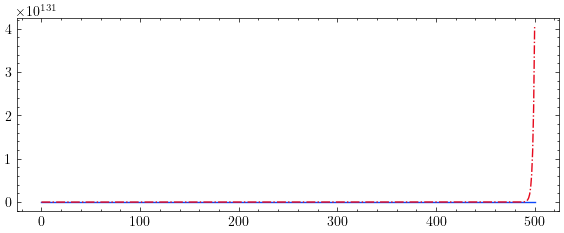

In [ ]:
with plt.style.context(['science', 'high-vis']):
    plt.figure(figsize=(7,2.5))
    plt.plot(Time, Yval)
    plt.plot(Time, Yvalr_armax,'-.')
    plt.show()

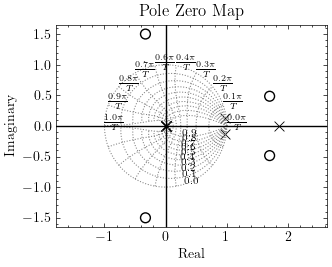

In [ ]:
cnt.pzmap(sys_armax.G,grid=True)
plt.show()

In [ ]:
sys_arx = system_identification(ytot, Usim, 'ARX',IC='AIC')

suggested orders are: Na= 5 ; Nb= 5 Delay:  5


In [ ]:
Yidr_arx, Time, Xsim_idr_arx = cnt.matlab.lsim(sys_arx.G, Usim, Time)
Yvalr_arx, Time, Xsim_valr_arx = cnt.matlab.lsim(sys_arx.G, Uval, Time)

In [ ]:
1-(la.norm(Y1-Yidr_arx)/la.norm(Y1-np.mean(Y1))),1-(la.norm(Yval-Yvalr_arx)/la.norm(Yval-np.mean(Yval)))

(0.813438708177989, 0.8000222220724682)